In [8]:
import sys
import os



import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

In [9]:
lamdas=np.logspace(-4,2,20)
print(lamdas)
between_lamdas=np.linspace(-4,2,20)

[1.00000000e-04 2.06913808e-04 4.28133240e-04 8.85866790e-04
 1.83298071e-03 3.79269019e-03 7.84759970e-03 1.62377674e-02
 3.35981829e-02 6.95192796e-02 1.43844989e-01 2.97635144e-01
 6.15848211e-01 1.27427499e+00 2.63665090e+00 5.45559478e+00
 1.12883789e+01 2.33572147e+01 4.83293024e+01 1.00000000e+02]


In [10]:
net = ContTempNetwork.load('fig3_network')

In [11]:
list_forw_flows = []

for i in lamdas:
    list_forw_flows.append(FlowIntegralClustering(T_inter_list=net.inter_T[i],
                                  time_list=net.times,
                                  verbose=True))

PID  57856  : computing T_list
PID  57856  : computing integral
PID  57856  :  0  over  10449  took 0.00s
PID  57856  :  1000  over  10449  took 0.30s
PID  57856  :  2000  over  10449  took 0.34s
PID  57856  :  3000  over  10449  took 0.34s
PID  57856  :  4000  over  10449  took 0.34s
PID  57856  :  5000  over  10449  took 0.34s
PID  57856  :  6000  over  10449  took 0.34s
PID  57856  :  7000  over  10449  took 0.34s
PID  57856  :  8000  over  10449  took 0.35s
PID  57856  :  9000  over  10449  took 0.34s
PID  57856  :  10000  over  10449  took 0.41s
integral took 3.67s
PID  57856  : computing T_list
PID  57856  : computing integral
PID  57856  :  0  over  10449  took 0.00s
PID  57856  :  1000  over  10449  took 0.30s
PID  57856  :  2000  over  10449  took 0.36s
PID  57856  :  3000  over  10449  took 0.36s
PID  57856  :  4000  over  10449  took 0.37s
PID  57856  :  5000  over  10449  took 0.49s
PID  57856  :  6000  over  10449  took 0.35s
PID  57856  :  7000  over  10449  took 0.35s
PI

In [12]:
# #Single loop of louvain clustering
# for i in range(len(lamdas)):
#     list_forw_flows[i].find_louvain_clustering()

In [13]:
# # parallel lovain for single lamda
# flowintegralclustering = list_forw_flows[-1]
# clustering = SparseClustering(p1=flowintegralclustering.p1, p2=None,
#                        T=flowintegralclustering.T_list[-1], S=flowintegralclustering.I_list[0])
# clusters, stabilites, seeds = parallel_clustering.compute_parallel_clustering(clustering, num_repeat=3, nproc=3, 
#                                 verbose=True, n_meta_iter_max=1000, 
#                                 n_sub_iter_max=1000, 
#                                 clust_verbose=False, print_num_loops=False)

# avg_norm_var_information(clusters)

In [14]:
# Alternative way of parallelizing runs of louvain algorithm
# run_multi_louvain(clustering=clustering, num_repeat=3)

In [15]:
multi_res = {}

for i, lamda in enumerate(lamdas):
    flowintegralclustering = list_forw_flows[i]
    clustering = SparseClustering(p1=flowintegralclustering.p1, p2=None,
                        T=flowintegralclustering.T_list[-1], S=flowintegralclustering.I_list[0])
    clusters, stabilites, seeds = parallel_clustering.compute_parallel_clustering(clustering, num_repeat=10, nproc=3, 
                                verbose=True, n_meta_iter_max=1000, 
                                n_sub_iter_max=1000, 
                                clust_verbose=False, print_num_loops=False)
    multi_res[lamda] = clusters

avg_csize_forw = [np.mean([len(c) for c in \
                   multi_res[lamda] if len(c)>1]) for lamda in lamdas]

NVI_forw = [avg_norm_var_information(multi_res[lamda]) for lamda in lamdas]

    

**** PID  57856 starting pool of 3 processes for the clustering loop.
Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.
Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.
Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.
**** PID  58244 starting clustering at 2023-12-29 17:03:27  with seed 3470815066
**** PID  58245 starting clustering at 2023-12-29 17:03:27  with seed 1790090341
**** PID  58243 starting clustering at 2023-12-29 17:03:27  with seed 2161526991
**** PID  58244 sym clust took 0.0297s, finished at 2023-12-29 17:03:27 , in 2 loops.
**** PID **** PID  58243  58245 sym clust took 0.0201s, finished at 2023-12-29 17:03:27 , in 2 loops.
sym clust took 0.0201s, finished at 2023-12-29 17:03:27 , in 2 loops.
**** PID  58244 starting clustering at 2023-12-29 17:03:27  with seed 1275835616
**** PID  58243 starting clustering at 2023-12-29 17:03:27  with seed 2842806295
**** PID  58245 starting clustering at 2023-1

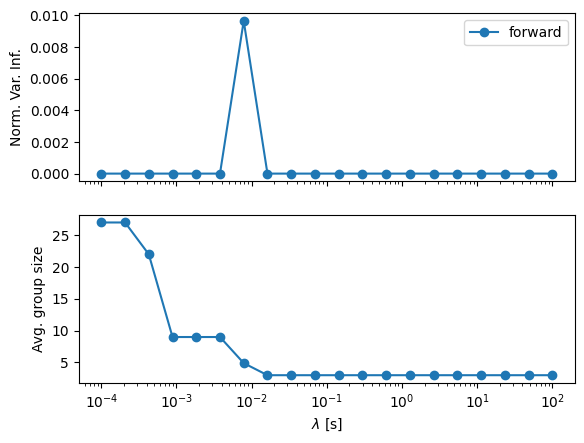

In [16]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)

    
ax1.plot(lamdas, NVI_forw, 'o-', label='forward')

ax2.plot(lamdas, avg_csize_forw, 'o-', label='forward')

ax1.set_xscale('log')

ax2.set_xlabel(r'$\lambda$ [s]')
ax1.set_ylabel('Norm. Var. Inf.')
ax2.set_ylabel('Avg. group size')
ax1.legend()

### Generating/Saving/Loading static networks

In [ ]:
# #Generating Networks

static_net_adj = net.compute_static_adjacency_matrix()

#weighted
#Combinatorial Laplacian
static_net_weighted_heat = StaticTempNetwork(times = net.times, adjacency = static_net_adj)
static_net_weighted_heat.compute_laplacian_matrices(random_walk = False)
# for i in lamdas:
#     static_net_weighted_heat.compute_inter_transition_matrices(lamda=i, dense_expm=False, use_sparse_stoch=False)
#     static_net_weighted_heat.compute_transition_matrices(lamda=i)

#Random Walk Laplacian
static_net_weighted = StaticTempNetwork(times = net.times, adjacency = static_net_adj)
static_net_weighted.compute_laplacian_matrices(random_walk = True)
# for i in lamdas:
#     static_net_weighted.compute_inter_transition_matrices(lamda=i, dense_expm=False, use_sparse_stoch=False)
#     static_net_weighted.compute_transition_matrices(lamda=i)


#unweighted
#entries are sum of durations of events, need to set to 1
static_net_adj = static_net_adj.toarray()
static_net_adj[static_net_adj != 0] = 1
static_net_adj = csr_matrix(static_net_adj)

#Combinatorial Laplacian
static_net_heat = StaticTempNetwork(times = net.times, adjacency = static_net_adj)
static_net_heat.compute_laplacian_matrices(random_walk = False)
# for i in lamdas:
#     static_net_heat.compute_inter_transition_matrices(lamda=i, dense_expm=False, use_sparse_stoch=False)
#     static_net_heat.compute_transition_matrices(lamda=i)

#Random Walk Laplacian
static_net = StaticTempNetwork(times = net.times, adjacency = static_net_adj)
static_net.compute_laplacian_matrices(random_walk = True)
# for i in lamdas:
#     static_net.compute_inter_transition_matrices(lamda=i, dense_expm=False, use_sparse_stoch=False)
#     static_net.compute_transition_matrices(lamda=i)

In [ ]:
#Saving Networks
static_net_weighted_heat.save('fig3_network_static_weighted_heat')
static_net_weighted.save('fig3_network_static_weighted')
static_net_heat.save('fig3_network_static_heat')
static_net.save('fig3_network_static')

In [ ]:
# #Loading Networks
# static_net_weighted_heat = StaticTempNetwork.load('fig3_network_static_weighted_heat')
# static_net_weighted = StaticTempNetwork.load('fig3_network_static_weighted')
# static_net_heat = StaticTempNetwork.load('fig3_network_static_heat')
# static_net = StaticTempNetwork.load('fig3_network_static')

In [ ]:
def one_time(s):
    one_time_s = []
    for key in s.keys():
        for i in s[key]:
            one_time_s.append(i)
    return one_time_s

def derivative(v1, v2):
    assert len(v1) == len(v2), "Error: in order to compute the numerical derivative, the two varibales need to have the same lenght."
    derivative = []
    for i, vi in enumerate(v1[1:]):
        m1 =(vi - v1[i-1])/(v2[i]-v2[i-1])
        m2 =(v1[i+1] - vi)/(v2[i+1]-v2[i])
        derivative.append((m1+m2)/2)
    return derivative

# Unweighted Static Network

### Spectral vNS

In [ ]:
for i in lamdas:
    static_net_heat.compute_spectral_vonNeumann_entropy(lamda=i, force_csr=True, time_domain = static_net_heat.times[-1:])

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(lamdas, one_time(static_net_heat.spectral_vNS))

plt.subplot(1, 2, 2)
plt.plot(lamdas, one_time(static_net_heat.spectral_vNS))
plt.yscale('log')
plt.title('Spectral vNS')

### Von Neumann Entropy

In [ ]:
for i in lamdas:
    static_net_heat.compute_vonNeumann_entropy(lamda=i, force_csr=True, time_domain = static_net_heat.times[-1:])

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(lamdas, one_time(static_net_heat.vNS))

plt.subplot(1, 2, 2)
plt.plot(lamdas, one_time(static_net_heat.vNS))
plt.yscale('log')
plt.title('vNS')

In [ ]:
#comparison between the two

print(one_time(static_net_heat.vNS))
print(one_time(static_net_heat.spectral_vNS))

## Derivatives

In [ ]:
St = []
for j, lamda in enumerate(lamdas):
    St = one_time(static_net_heat.vNS)

v1 = St
v2 = between_lamdas
ds_dt = derivative(v1, v2)

plt.subplot(1, 2, 1)
plt.plot(lamdas[1:], ds_dt, label='t = ')

plt.subplot(1, 2, 2)
plt.plot(lamdas[1:], ds_dt, label='t = ')
plt.xscale('log')

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Static Network: d(Spectral vNS) / dlamda')
#plt.savefig('./figures/fig3_recap_entropy_plots/fig3_dspectral_vNS_dlamda.eps', format='eps')

plt.show()

# Weighted Static network

In [ ]:
for i in lamdas:
    static_net_weighted_heat.compute_spectral_vonNeumann_entropy(lamda=i, force_csr=True, time_domain = static_net_weighted_heat.times[-1:])

In [ ]:
for i in lamdas:
    static_net_weighted_heat.compute_vonNeumann_entropy(lamda=i, force_csr=True, time_domain = static_net_weighted_heat.times[-1:])

In [ ]:
#comparison between the two

print(one_time(static_net_weighted_heat.vNS))
print(one_time(static_net_weighted_heat.spectral_vNS))

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(lamdas, one_time(static_net_weighted_heat.vNS))

plt.subplot(1, 2, 2)
plt.plot(lamdas, one_time(static_net_weighted_heat.vNS))
plt.yscale('log')
plt.title('vNS')

In [ ]:
for j, lamda in enumerate(lamdas):
    St = one_time(static_net_weighted_heat.vNS)

    v1 = St
    v2 = between_lamdas
    ds_dt = derivative(v1, v2)

plt.subplot(1, 2, 1)
plt.plot(lamdas[1:], ds_dt, label='t = ')

plt.subplot(1, 2, 2)
plt.plot(lamdas[1:], ds_dt, label='t = ')
plt.xscale('log')

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Static Network: d(vNS) / dlamda')
#plt.savefig('./figures/fig3_recap_entropy_plots/fig3_dvNS_dlamda.eps', format='eps')

plt.show()

# Static Network Random Walk 

In [ ]:
for i in lamdas:
    static_net.compute_vonNeumann_entropy(lamda=i, force_csr=True, time_domain = static_net_heat.times[-1:])

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(lamdas, one_time(static_net.vNS))

plt.subplot(1, 2, 2)
plt.plot(lamdas, one_time(static_net.vNS))
plt.yscale('log')
plt.title('vNS')

In [ ]:
St = []
for j, lamda in enumerate(lamdas):
    St = one_time(static_net.vNS)

v1 = St
v2 = between_lamdas
ds_dt = derivative(v1, v2)

plt.subplot(1, 2, 1)
plt.plot(lamdas[1:], ds_dt, label='t = ')

plt.subplot(1, 2, 2)
plt.plot(lamdas[1:], ds_dt, label='t = ')
plt.xscale('log')

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Static Network: d(vNS) / dlamda')
#plt.savefig('./figures/fig3_recap_entropy_plots/fig3_dspectral_vNS_dlamda.eps', format='eps')

plt.show()

# Weighted Static Network Random Walk

In [ ]:
for i in lamdas:
    static_net_weighted.compute_vonNeumann_entropy(lamda=i, force_csr=True, time_domain = static_net_heat.times[-1:])

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(lamdas, one_time(static_net_weighted.vNS))

plt.subplot(1, 2, 2)
plt.plot(lamdas, one_time(static_net_weighted.vNS))
plt.yscale('log')
plt.title('vNS')

In [ ]:
St = []
for j, lamda in enumerate(lamdas):
    St = one_time(static_net_weighted.vNS)

v1 = St
v2 = between_lamdas
ds_dt = derivative(v1, v2)

plt.subplot(1, 2, 1)
plt.plot(lamdas[1:], ds_dt, label='t = ')

plt.subplot(1, 2, 2)
plt.plot(lamdas[1:], ds_dt, label='t = ')
plt.xscale('log')

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Static Network: d(vNS) / dlamda')
#plt.savefig('./figures/fig3_recap_entropy_plots/fig3_dspectral_vNS_dlamda.eps', format='eps')

plt.show()

In [ ]:
with open('test_lamda100.000000', 'rb') as f:
    pickle_test = pickle.load(f)

In [ ]:
pickle_test.keys()

In [ ]:
len(pickle_test['vNS'])

In [ ]:
pickle_test['vNS']

In [ ]:
tuple([round(lamda, 6) for lamda in lamdas ])

In [ ]:
file='fig3_lamdas'
lamdasf6= [round(lamda, 6) for lamda in lamdas ]
with open(file, "w") as output:
    output.write('(')
    for lamda in lamdasf6[:-1]:
        output.write(str(lamda) + ' ' )
    output.write(str(lamdasf6[-1]) + ')')